In [1]:
import gensim.downloader as api
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
# from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score


2025-03-24 23:16:50.058508: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 23:16:50.061638: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 23:16:50.114027: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 23:16:50.115168: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-24 23:16:51.196467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [16]:
csv = "../../data/contaminated/contaminated_data_bis.csv"
contaminated = pd.read_csv(csv).iloc[:, 0]
indices = np.load("../../data/contaminated/indices_anomalies_bis.npy").flatten().tolist()

In [17]:
def vetorisation_sbert(data, indice_anomalie=None):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    vecteurs = model.encode(data)
    vecteurs = np.array(vecteurs)

    tsne = TSNE(n_components=2, random_state=42)  
    vecteurs_2d = tsne.fit_transform(vecteurs)  
    
    # couleurs des points ( rouge : anomalie, bleu : noraml)
    couleurs = ['b'] * len(data)
    if indice_anomalie:
        for i in indice_anomalie:
            if 0 <= i < len(data): 
                couleurs[i] = 'r'

    plt.figure(figsize=(60, 30)) 
    plt.scatter(vecteurs_2d[:, 0], vecteurs_2d[:, 1], c=couleurs, marker='o') 

    plt.title("Représentation graphique des documents vectorisés")
    plt.grid(True)
    #plt.savefig("output.jpg")
    plt.show()
    return vecteurs

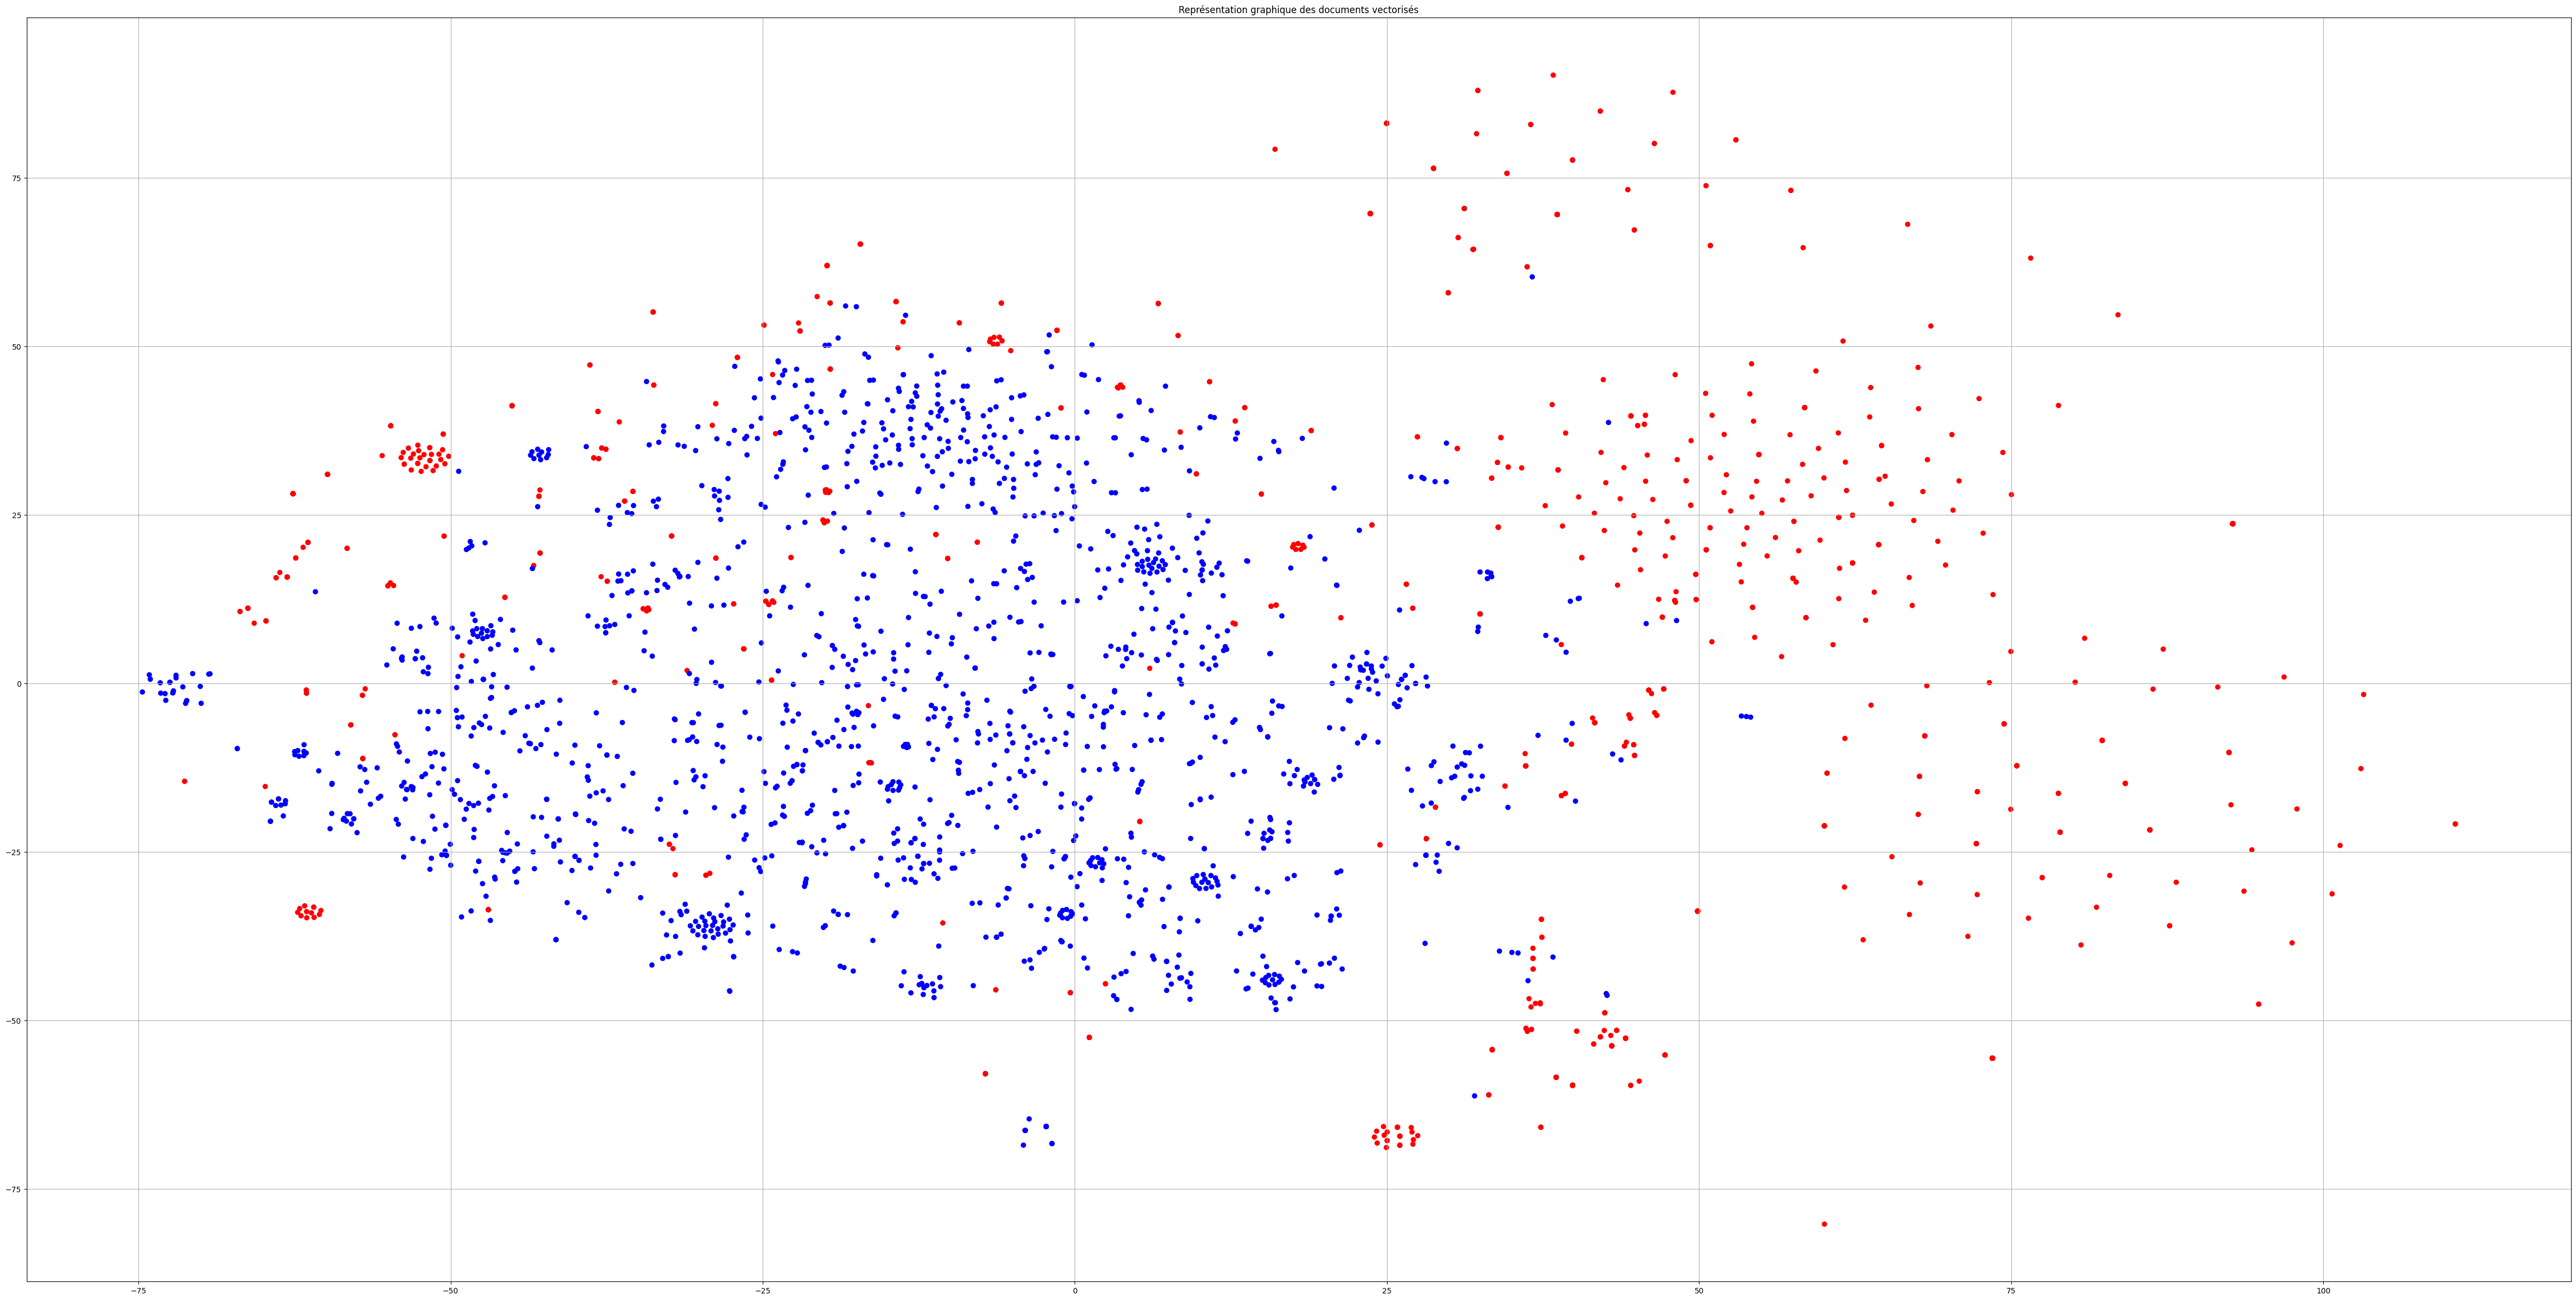

In [18]:
anomalie_sb = vetorisation_sbert(contaminated, indices)

In [19]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim) 
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [20]:
anomalie_tensor = torch.tensor(anomalie_sb, dtype=torch.float32)
dataset = TensorDataset(anomalie_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = Autoencoder(input_dim=anomalie_sb.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0] 
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/50, Loss: 0.0008
Epoch 2/50, Loss: 0.0007
Epoch 3/50, Loss: 0.0006
Epoch 4/50, Loss: 0.0003
Epoch 5/50, Loss: 0.0004
Epoch 6/50, Loss: 0.0003
Epoch 7/50, Loss: 0.0003
Epoch 8/50, Loss: 0.0003
Epoch 9/50, Loss: 0.0003
Epoch 10/50, Loss: 0.0003
Epoch 11/50, Loss: 0.0004
Epoch 12/50, Loss: 0.0003
Epoch 13/50, Loss: 0.0003
Epoch 14/50, Loss: 0.0003
Epoch 15/50, Loss: 0.0003
Epoch 16/50, Loss: 0.0004
Epoch 17/50, Loss: 0.0003
Epoch 18/50, Loss: 0.0003
Epoch 19/50, Loss: 0.0003
Epoch 20/50, Loss: 0.0004
Epoch 21/50, Loss: 0.0003
Epoch 22/50, Loss: 0.0003
Epoch 23/50, Loss: 0.0003
Epoch 24/50, Loss: 0.0002
Epoch 25/50, Loss: 0.0004
Epoch 26/50, Loss: 0.0003
Epoch 27/50, Loss: 0.0003
Epoch 28/50, Loss: 0.0003
Epoch 29/50, Loss: 0.0003
Epoch 30/50, Loss: 0.0003
Epoch 31/50, Loss: 0.0003
Epoch 32/50, Loss: 0.0003
Epoch 33/50, Loss: 0.0003
Epoch 34/50, Loss: 0.0003
Epoch 35/50, Loss: 0.0004
Epoch 36/50, Loss: 0.0003
Epoch 37/50, Loss: 0.0003
Epoch 38/50, Loss: 0.0003
Epoch 39/50, Loss: 0.


🔥 Meilleur seuil trouvé : 0.000009
📈 F1-score optimal : 0.5204

📊 Rapport de classification :

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00      1645
    Anomalie       0.37      0.88      0.52      1096

    accuracy                           0.35      2741
   macro avg       0.18      0.44      0.26      2741
weighted avg       0.15      0.35      0.21      2741

AUC ROC : 0.3085


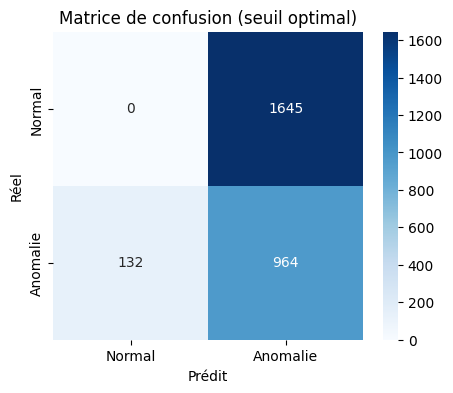

In [21]:
model.eval()
with torch.no_grad():
    inputs = torch.tensor(anomalie_sb, dtype=torch.float32)
    reconstructions = model(inputs)
    mse = torch.mean((inputs - reconstructions) ** 2, dim=1)

mse = mse.numpy()  # Convertir en numpy pour sklearn


# labels = [indices des anomalies connues]
labels = np.zeros(anomalie_sb.shape[0])
labels[indices] = 1
labels = labels.astype(int)

# le meilleur seuil basé sur le F1-score 

thresholds = np.linspace(mse.min(), mse.max(), 200)
best_f1 = 0
best_threshold = 0

f1_scores = []

for t in thresholds:
    preds = (mse > t).astype(int)
    f1 = f1_score(labels, preds)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\n🔥 Meilleur seuil trouvé : {best_threshold:.6f}")
print(f"📈 F1-score optimal : {best_f1:.4f}")

# evaluer avec le meilleur seuil

y_pred = (mse > best_threshold).astype(int)
y_true = labels

print("\n📊 Rapport de classification :\n")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomalie"]))

y_score = mse 
roc_auc = roc_auc_score(y_true, y_score)

print(f"AUC ROC : {roc_auc:.4f}")

# matrice de confusion 

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion (seuil optimal)")
plt.show()


In [22]:
mse_series = pd.Series(mse, name="MSE")
print(mse_series.describe())

count    2741.000000
mean        0.000260
std         0.000194
min         0.000009
25%         0.000105
50%         0.000234
75%         0.000394
max         0.001063
Name: MSE, dtype: float64


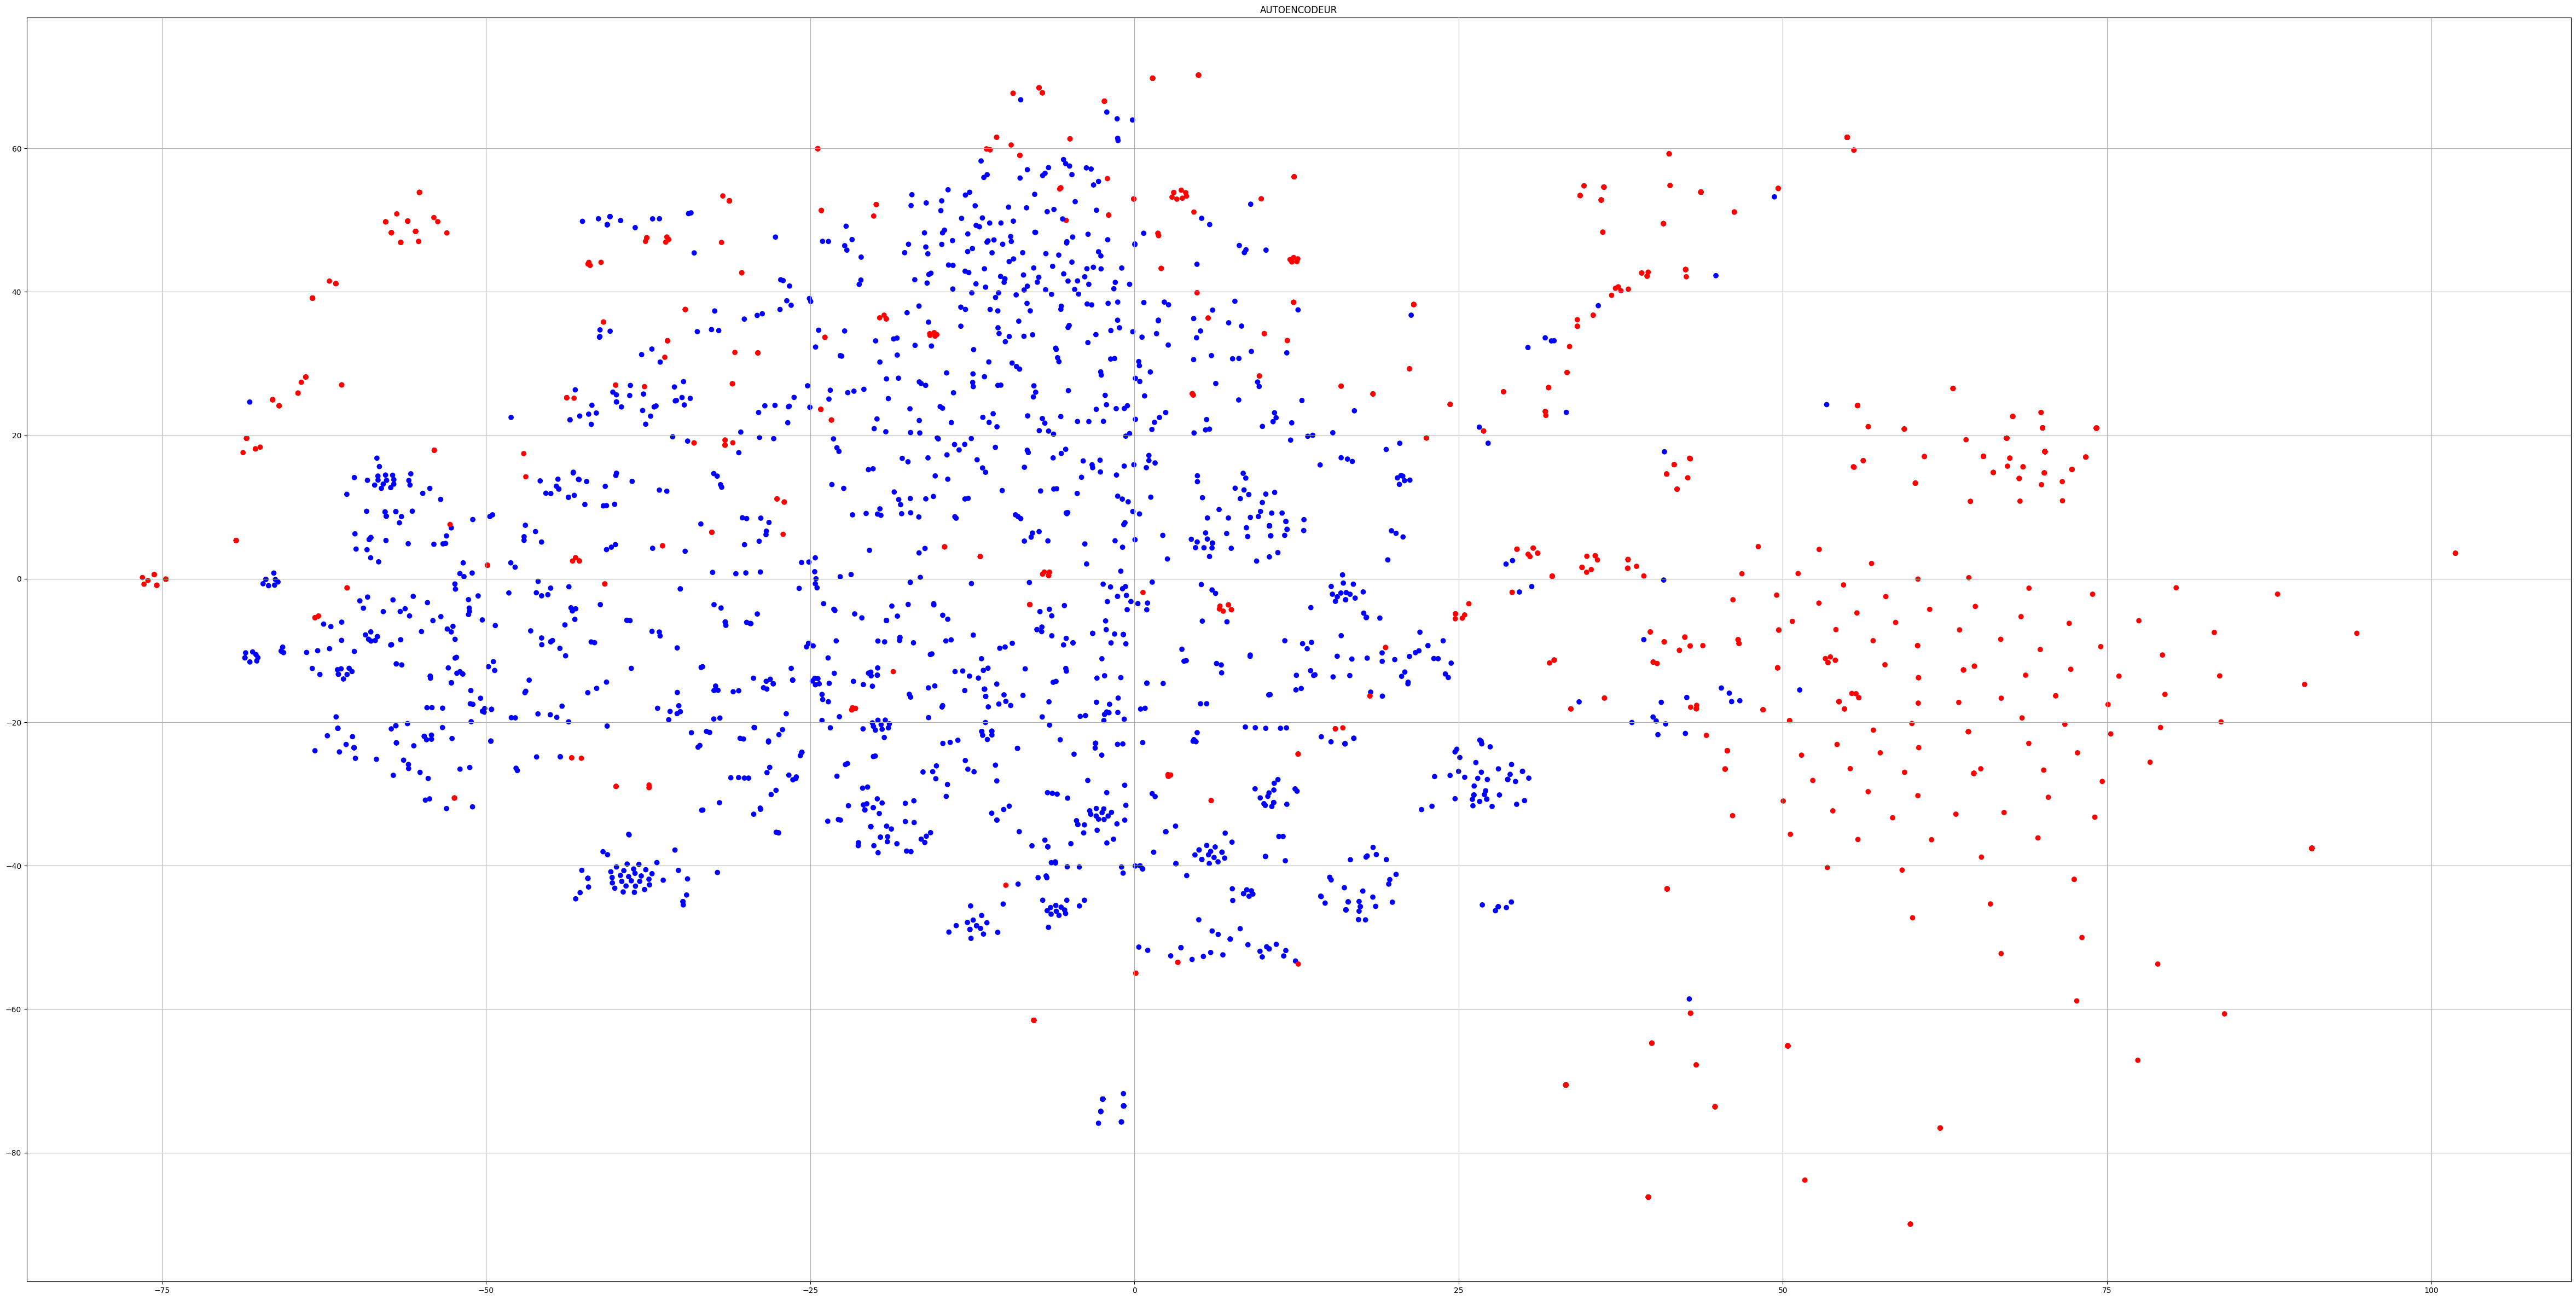

In [23]:
tsne = TSNE(n_components=2, random_state=42)  # réduire à 2 dimensions
reconstructed_2d = tsne.fit_transform(reconstructions)  # appliquer t-SNE

# couleurs des points ( rouge : anomalie, bleu : noraml)
couleurs = ['b'] * len(anomalie_sb)
for i in indices:
    if 0 <= i < len(anomalie_sb): 
        couleurs[i] = 'r'

# affichage graphique des données dans l'espace 2D
plt.figure(figsize=(60, 30)) 
plt.scatter(reconstructed_2d[:, 0], reconstructed_2d[:, 1], c=couleurs, marker='o') 

plt.title("AUTOENCODEUR")
plt.grid(True)
#plt.savefig("output.jpg")
plt.show()

In [24]:
isolation_forest = IsolationForest()
isolation_forest.fit(anomalie_sb)

IsolationForest()

In [25]:
i_forest = isolation_forest.decision_function(anomalie_sb)
anomaly_scores = -i_forest #anomalie >


📊 Rapport de classification :
              precision    recall  f1-score   support

      Normal       1.00      0.00      0.00      1645
    Anomalie       0.40      1.00      0.57      1096

    accuracy                           0.40      2741
   macro avg       0.70      0.50      0.29      2741
weighted avg       0.76      0.40      0.23      2741

🎯 AUC ROC : 0.4505


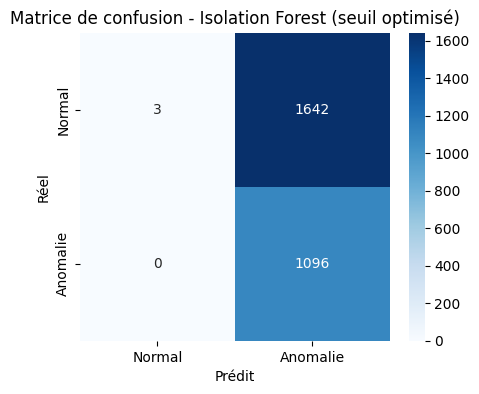

In [26]:
thresholds = np.linspace(min(anomaly_scores), max(anomaly_scores), 200)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    preds = (anomaly_scores >= t).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

y_pred = (anomaly_scores >= best_threshold).astype(int)

print("\n📊 Rapport de classification :")
print(classification_report(labels, y_pred, target_names=["Normal", "Anomalie"]))

roc_auc = roc_auc_score(labels, anomaly_scores)

print(f"🎯 AUC ROC : {roc_auc:.4f}")
# Matrice de confusion
cm = confusion_matrix(labels, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Isolation Forest (seuil optimisé)")
plt.show()

In [27]:
oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05) 
oc_svm.fit(anomalie_sb)

OneClassSVM(nu=0.05)

In [28]:
svm_pred = oc_svm.decision_function(anomalie_sb)
svm_scores = -svm_pred #anomalie >


📊 Rapport de classification :
              precision    recall  f1-score   support

      Normal       0.81      0.47      0.60      1645
    Anomalie       0.51      0.84      0.64      1096

    accuracy                           0.62      2741
   macro avg       0.66      0.65      0.62      2741
weighted avg       0.69      0.62      0.61      2741

🎯 AUC ROC : 0.6666


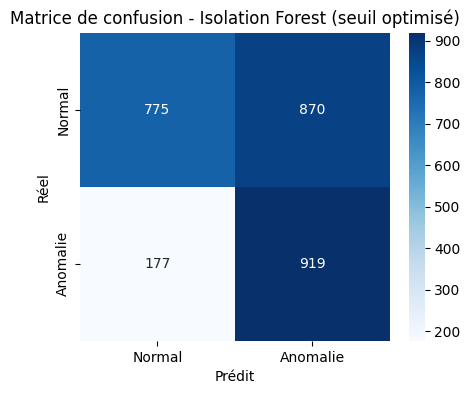

In [29]:
thresholds = np.linspace(min(svm_scores), max(svm_scores), 200)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    preds = (svm_scores >= t).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

y_pred = (svm_scores >= best_threshold).astype(int)

print("\n📊 Rapport de classification :")
print(classification_report(labels, y_pred, target_names=["Normal", "Anomalie"]))

roc_auc = roc_auc_score(labels, svm_scores)

print(f"🎯 AUC ROC : {roc_auc:.4f}")
# Matrice de confusion
cm = confusion_matrix(labels, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Isolation Forest (seuil optimisé)")
plt.show()